In [10]:
%matplotlib inline

import torchvision
import torch
from torchvision.transforms import transforms
from torchvision.datasets.utils import download_url
import os
import tarfile
import hashlib
import numpy as np

import matplotlib.pyplot as plt

# ⬇️ Download Dataset

In [2]:
# https://github.com/fastai/imagenette
dataset_url = 'https://s3.amazonaws.com/fast-ai-imageclas/imagenette2.tgz'
dataset_filename = dataset_url.split('/')[-1]
dataset_foldername = dataset_filename.split('.')[0]
data_path = './data'
dataset_filepath = os.path.join(data_path,dataset_filename)
dataset_folderpath = os.path.join(data_path,dataset_foldername)

os.makedirs(data_path, exist_ok=True)

download = False
if not os.path.exists(dataset_filepath):
    download = True
else:
    md5_hash = hashlib.md5()


    file = open(dataset_filepath, "rb")

    content = file.read()

    md5_hash.update(content)


    digest = md5_hash.hexdigest()
    if digest != 'fe2fc210e6bb7c5664d602c3cd71e612':
        download = True
if download:
    download_url(dataset_url, data_path)

with tarfile.open(dataset_filepath, 'r:gz') as tar:
    tar.extractall(path=data_path)

  0%|          | 0/1557161267 [00:00<?, ?it/s]

In [3]:
class TwoCropsTransform:
    """Take two random crops of one image as the query and key."""

    def __init__(self, base_transform):
        self.base_transform = base_transform

    def __call__(self, x):
        q = self.base_transform(x)
        k = self.base_transform(x)
        return [q, k]

    def __repr__(self):
        format_string = self.__class__.__name__ + '(\n\t'
        format_string += self.base_transform.__repr__().replace('\n', '\n\t')
        format_string += '\n)'
        return format_string

In [13]:
size  = 224
ks = (int(0.1 * size) // 2) * 2 + 1 # should be odd
__imagenet_stats = {'mean': [0.485, 0.456, 0.406],
                    'std': [0.229, 0.224, 0.225]}

train_transform = TwoCropsTransform(transforms.Compose([transforms.RandomResizedCrop(scale=(0.2, 1), size=size),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomApply([transforms.ColorJitter(0.8, 0.8, 0.8, 0.2)], p=0.8),
                                      transforms.RandomGrayscale(p=0.2),
                                      transforms.GaussianBlur(kernel_size=ks),
                                      transforms.ToTensor(),
                                      transforms.Normalize(**__imagenet_stats)
                                    ]))

image_folder_dir = os.path.join(dataset_folderpath,'train')
dataset_train = torchvision.datasets.ImageFolder(image_folder_dir, train_transform)
#valid_ds = ImageFolder('./data/imagenette-160/val', valid_tfms)

batch_size = 4
train_dataloader = torch.utils.data.DataLoader(
        dataset_train,
        batch_size=batch_size,
        num_workers=8,
        #drop_last=True,
        #shuffle=True,
)


In [14]:
def get_numpy_samples(inputs):
        mean = torch.as_tensor(__imagenet_stats['mean'], dtype=inputs.dtype, device=inputs.device)
        std = torch.as_tensor(__imagenet_stats['std'], dtype=inputs.dtype, device=inputs.device)
        inputs = inputs * std.view(1, -1, 1, 1) + mean.view(1, -1, 1, 1)
        inputs = inputs.numpy()
        inputs = np.transpose(inputs, (0,2,3,1))
        return inputs

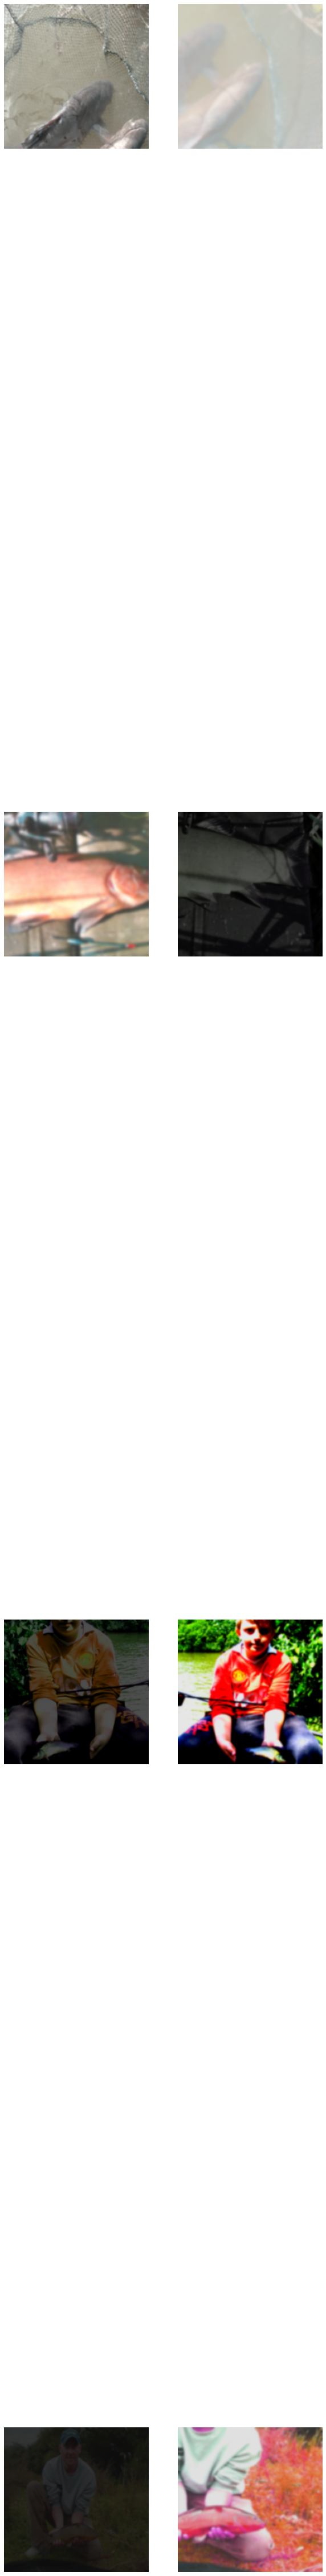

In [15]:
fig, axes = plt.subplots(nrows=batch_size, ncols=2, figsize=(10,100))
for (input1, input2), _ in train_dataloader:
    np_inputs1, np_inputs2 = get_numpy_samples(input1), get_numpy_samples(input2)
    for row in range(batch_size):
        axes[row, 0].axis("off")
        axes[row, 0].imshow(np_inputs1[row])
        axes[row, 1].axis("off")
        axes[row, 1].imshow(np_inputs2[row])
    break
plt.show()

# 🧪 MOCO